# **Assignment 5**

Turn in the assignment via Canvas.

To write legible answers you will need to be familiar with both [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) and [Latex](https://www.latex-tutorial.com/tutorials/amsmath/)

Before you turn this problem in, make sure everything runs as expected. First, restart the kernel (in the menubar, select Kernel→→Restart) and then run all cells (in the menubar, select Cell→→Run All).

Make sure you fill in any place that says "YOUR CODE HERE" or "YOUR ANSWER HERE", as well as your name below:

In [0]:
NAME = ""
STUDENT_ID = ""

Some imports we will need:

In [0]:
import tensorflow as tf
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import numpy as np
import string
import textwrap
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, Dense, Dropout, Input, LSTM, GRU, Bidirectional, Flatten
from tensorflow.keras.models import Model

We will be expanding on the in class exercise and doing classification using an RNN but now with multiple labels instead of binary labels.

We will be using the [Reuters newswire](https://keras.io/api/datasets/reuters/) classification dataset, which has text paired with 46 topics as labels. You can see what these labels represent [here](https://martin-thoma.com/nlp-reuters/).

Let's load the data:

In [0]:
(X_train, y_train), (_, _) = reuters.load_data()

2113536/2110848 [==============================] - 0s 0us/step


In [0]:
# https://stackoverflow.com/questions/42821330/restore-original-text-from-keras-s-imdb-dataset
# Needed to encode our own reviews later

word_dict = reuters.get_word_index()
word_dict = {k:(v+3) for k,v in word_dict.items()}
word_dict["<PAD>"] = 0
word_dict["<START>"] = 1
word_dict["<UNK>"] = 2
word_dict["<UNUSED>"] = 3

vocab_size = len(word_dict.keys())

557056/550378 [==============================] - 0s 0us/step


In [0]:
# Needed to decode training data into readable text

inverse_word_dict = {value:key for key,value in word_dict.items()}

In [0]:
X_train = np.array(X_train)
X_train = pad_sequences(X_train)

max_sequence_len = X_train[0].shape[0]
print('Padded to longest sequence length: ', max_sequence_len)

Padded to longest sequence length:  2376


In [0]:
y_train = to_categorical(y_train, 46)
y_train = np.array(y_train)

In [0]:
print('Number of words in vocabulary: ', vocab_size)

Number of words in vocabulary:  30983


In [0]:
def encode_text(text, word_dict, maxlen):
  encoded_text = []
  for raw_word in text.split(' '):
    word = raw_word.strip().strip(string.punctuation).lower()
    if word is '' or word is '\n':
      continue
    try:
      encoded_text.append(word_dict[word])
    except KeyError as e:
      # raise KeyError(f'{e} not in word dictionary, text not encoded.')
      continue
  return pad_sequences(np.array(encoded_text).reshape(1,-1), maxlen=maxlen)

def decode_text(encoded_text, inverse_word_dict):
  sentence = []
  for encoded_word in encoded_text:
    if encoded_word == 0:
      continue
    sentence.append(inverse_word_dict[encoded_word])
  w = textwrap.TextWrapper(width=120,break_long_words=False,replace_whitespace=False)
  return '\n'.join(w.wrap(' '.join(sentence)))

Let's take a look at an article in our training data:

In [0]:
idx = 144

print(decode_text(X_train[idx], inverse_word_dict), end='\n\n')

print('Topic: ', y_train[idx])

<START> lt black hawk mining inc said it knows of no major activities to account for the recent rise in the company's
stock price the shares rose 11 cts to 88 cts on the toronto stock exchange yesterday the company added that its
application for its proposed acquisition of lt platinova resources ltd and financings are still before the listing
committee of the stock exchange reuter 3

Topic:  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


##Question 1

Create a model using an RNN layer (LSTM or GRU, unidirectional or bidirectional) to achieve at least 60% validation accuracy in 10 epochs or less:

In [0]:
### YOUR CODE HERE ###

num_categories = 46

# Reminder: We have 46 categories. What final activation do we need to use?

input_layer = Input(shape=(max_sequence_len))

x = Embedding(vocab_size, 256)(input_layer)
# x = Bidirectional(LSTM(128))(x) 
x = LSTM(128)(x) 
x = Dense(128, activation='relu')(x)
# x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
# 
x = Dropout(0.5)(x)
x = Dense(num_categories, activation='softmax')(x)

topic_model = Model(input_layer, x)


In [0]:
topic_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2376)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 2376, 256)         7931648   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               197120    
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160  

Compile your model and display the summary:

In [0]:
loss ='categorical_crossentropy'### YOUR CODE HERE ###

opt = 'RMSprop' ### YOUR CODE HERE ###

metrics = ['accuracy'] ### YOUR CODE HERE ###

topic_model.compile(loss=loss,
              optimizer=opt,
              metrics=metrics)

topic_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2376)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 2376, 256)         7931648   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               197120    
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160  

Train your model:

In [0]:
batchsize = 16 ### YOUR CODE HERE ###
numEpochs = 8
history = topic_model.fit(X_train, y_train, batch_size=batchsize, epochs=numEpochs, validation_split=0.2, shuffle=True)

Epoch 1/8
450/450 [==============================] - 78s 174ms/step - loss: 2.1777 - accuracy: 0.4397 - val_loss: 1.9441 - val_accuracy: 0.4040
Epoch 2/8
450/450 [==============================] - 78s 174ms/step - loss: 1.7941 - accuracy: 0.5381 - val_loss: 1.6536 - val_accuracy: 0.5710
Epoch 3/8
450/450 [==============================] - 78s 174ms/step - loss: 1.6290 - accuracy: 0.5804 - val_loss: 1.6887 - val_accuracy: 0.5776
Epoch 4/8
450/450 [==============================] - 79s 174ms/step - loss: 1.5595 - accuracy: 0.5893 - val_loss: 1.6568 - val_accuracy: 0.5754
Epoch 5/8
450/450 [==============================] - 79s 175ms/step - loss: 1.4953 - accuracy: 0.6075 - val_loss: 1.6520 - val_accuracy: 0.5943
Epoch 6/8
450/450 [==============================] - 79s 175ms/step - loss: 1.4228 - accuracy: 0.6195 - val_loss: 1.5652 - val_accuracy: 0.5843
Epoch 7/8
450/450 [==============================] - 79s 175ms/step - loss: 1.3455 - accuracy: 0.6402 - val_loss: 1.6829 - val_accuracy:

Plot the training and validation losses and accuracies:

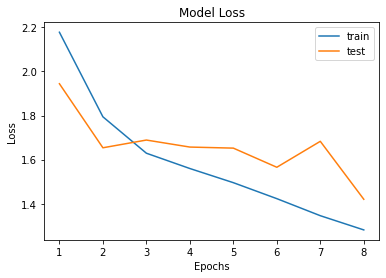

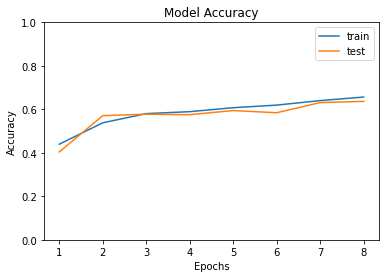

In [0]:
### YOUR CODE HERE ###

plt.plot([x+1 for x in range(numEpochs)], history.history['loss'])
plt.plot([x+1 for x in range(numEpochs)], history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

plt.plot([x+1 for x in range(numEpochs)], history.history['accuracy'])
plt.plot([x+1 for x in range(numEpochs)], history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.ylim([0,1])
plt.show()

##Question 2



We've seen both LSTM and GRU cells as building blocks for RNNs.

Here is a reminder of each of their corresponding architectures:

![Pic](https://drive.google.com/uc?id=1INZQkDev_8rdFxOT9hfAiPWJRT6-N82S)

i) What are the major differences between each?

LSTM (Long Short Term Memory): LSTM has three gates (input, output and forget gate), the input decides 

GRU (Gated Recurring Units): GRU has two gates (reset and update gate).

ii) What are the major advantages of each?

GRU use less training parameters and therefore use less memory, as a result GRU executes faster and trains faster than LSTM. 

LSTM learns more parameters and can generate more complex models. Additionally it is more accurate on datasets using longer sequences. 

iii) What are the major disadvantages of each?

LSTM suffers where GRU excels, and vice versa. LSTM uses more parameters and can give it an edge when it comes to learning features of longer sequences, but it suffers from larger memory usage and training time.

GRU is a simpler model, bypassing the need for a memory unit entirely with its forget gate. Its simplicity however theoretically makes it less likely to remember longer sequences. 
